## HW 2
Botasheva Zhanna

## Практика по PyTorch

### Задание:

Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у.
В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

### Результаты:

a) Посчитать метрику Mean Square Error(MSE) на test.

b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

In [2]:
import numpy as np # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек
import torch # Библиотека глубокого обучения
from torch import nn # функция потерь
import torch.optim as optim #оптимизатор
import matplotlib.pyplot as plt # для визуализации данных
import seaborn as sns
import random # Генерация случайных чисел
import math # содержит наиболее применяемые математические функции и константы
import tqdm # индикатор прогресса
import copy # для копирования объектов

In [3]:
def funct(x,y):
    return torch.sin(x+2*y)*torch.exp(-(2*x+y)**2)

In [30]:
x = (torch.rand(20000))*20-10
y = (torch.rand(20000))*20-10
x = x[None,:]; y = y[None,:]
z = funct(x,y)

data = torch.concat([x,y,z],dim=0).t()
numpy_data = data.numpy()
df = pd.DataFrame(numpy_data,columns=['x', 'y', 'z'])
df

,x,y,z
0,-3.647344,3.794699,-3.434420e-06
1,5.474796,-5.150368,2.462830e-15
2,-3.698172,-3.415150,0.000000e+00
3,-9.257888,1.353021,-0.000000e+00
4,7.533676,4.517063,-0.000000e+00
...,...,...,...
19995,-0.068780,0.010043,-4.788934e-02
19996,-4.501099,5.822607,3.085310e-05
19997,9.859364,6.568264,-0.000000e+00
19998,-6.040157,9.758240,3.594250e-03


In [31]:
# Разбиваем выборку на три части

train, validate, test = np.split(df.sample(frac=1),[int(0.7*len(df)),int(0.85*len(df))])
print(f'train {train.shape[0]/df.shape[0]}')
print(f'validate {validate.shape[0]/df.shape[0]}')
print(f'test {test.shape[0]/df.shape[0]}')

train 0.7
validate 0.15
test 0.15


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [32]:
# конвертируем обратно в tensor

train = torch.FloatTensor(train.values)
validate = torch.FloatTensor(validate.values)
test = torch.FloatTensor(test.values)

print(train.size(),validate.size(),test.size())

torch.Size([14000, 3]) torch.Size([3000, 3]) torch.Size([3000, 3])


In [33]:
# определяем целевую перемнную z и нецелевые x,y

x_train = train[:,:2]; y_train = train[:,2].squeeze()
x_val = validate[:,:2]; y_val = validate[:,2].squeeze()
x_test = test[:,:2]; y_test = test[:,2].squeeze()

In [34]:
# model

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(in_features=2, out_features=100)
        self.act_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=100,out_features=200)
        self.act_2 = nn.ReLU()
        self.linear_3 = nn.Linear(in_features=200,out_features=100)
        self.act_3 = nn.ReLU()
        self.linear_4 = nn.Linear(in_features=100,out_features=50)
        self.act_4 = nn.ReLU()
        self.linear_5 = nn.Linear(in_features=50,out_features=1)

    def forward(self,x):
        x = self.linear_1(x)
        x = self.act_1(x)
        x = self.linear_2(x)
        x= self.act_2(x)
        x = self.linear_3(x)
        x = self.act_3(x)
        x = self.linear_4(x)
        x = self.act_4(x)
        x = self.linear_5(x)
        return x

''' Define device and model '''

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = Net().to(device)

Using cuda device


In [35]:
# определяем оптимизатор и критерии оценки результата

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()

In [36]:
# Тренировочный цикл, используем мини батчи

lst_loss = []; lst_iter = []
for epoch_index in tqdm.tqdm(range(50000)):

    x_train = x_train.to(device)
    y_train = y_train.to(device)

    # use randomised mini-batch
    ix = torch.randint(0, x_train.shape[0], size=(32,))

    optimizer.zero_grad()
    y_pred = model(x_train[ix])

    # MSE loss
    loss = criterion(y_pred.squeeze(), y_train[ix])

    if(epoch_index % 1000 == 0):
        lst_loss.append(loss.item())
        lst_iter.append(epoch_index)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 50000/50000 [01:48<00:00, 461.79it/s]


Text(0.5, 1.0, 'Функция потерь')

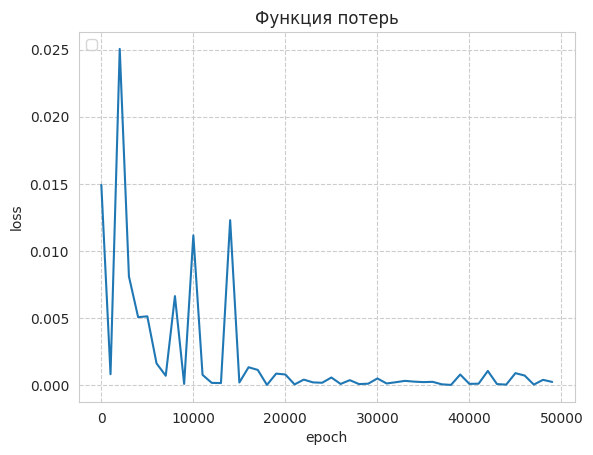

In [37]:
sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })

plt.plot(lst_iter,lst_loss,)
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Функция потерь')

In [38]:
# функция для сравнения истинных и предсказанных значений

def compare_y(net,x,y,title:str):

    sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })

    x = x.to(device)
    y = y.to(device)

    # make prediction
    y_pred = net.forward(x)
    y2 = y_pred.cpu().detach().numpy()[:,0]
    mse_loss = criterion(y_pred.squeeze(), y)
    print(f'mse: {mse_loss}')

    plt.plot(y_pred.cpu().detach().numpy(),
             y.cpu().detach().numpy(), 'o', mec='k',ms=5)

    plt.legend(loc='upper left')
    plt.xlabel('y_model')
    plt.ylabel('y_true')
    plt.title(title)

mse: 0.0003884654142893851


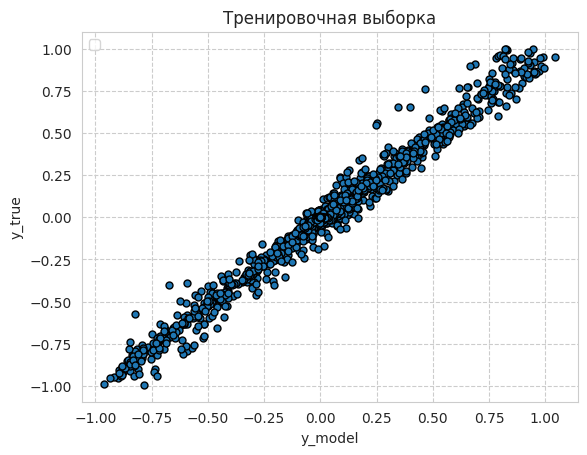

mse: 0.00041015027090907097


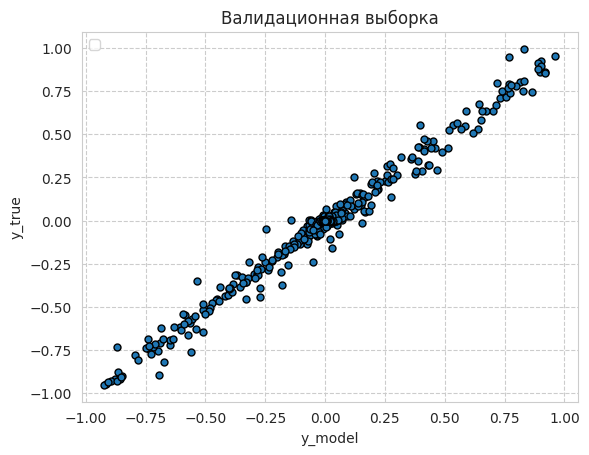

mse: 0.0004895797464996576


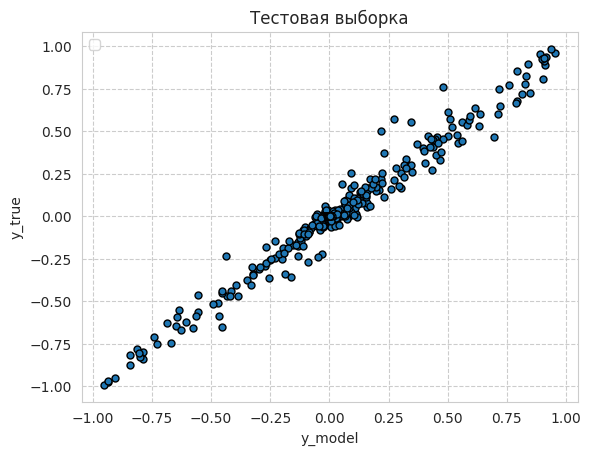

In [39]:
compare_y(model,x_train,y_train,'Тренировочная выборка'); plt.show()
compare_y(model,x_val,y_val,'Валидационная выборка'); plt.show()
compare_y(model,x_test,y_test,'Тестовая выборка'); plt.show()

In [40]:
# функция для сравнения истинных и предсказанных значений 3D

from mpl_toolkits.mplot3d import Axes3D

def compare_pred(net,x,y,title:str):

    sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })

    x = x.to(device)
    y = y.to(device)

    # create meshgrid
    xg, yg = torch.meshgrid(x[:,0], x[:,0], indexing='xy')

    x1 = x[:,0].cpu()
    x2 = x[:,1].cpu()
    y1 = y.cpu()

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_trisurf(x1,x2,y1, linewidth=0.0,edgecolors=None,alpha=0.3)
    ax.scatter(x1,x2,y1,edgecolor='black', linewidth=0.5, facecolor=None,s=8)
    ax.view_init(20, 35)
    ax.set_title('Истинные Значения')

    # make prediction
    y_pred = net.forward(x)
    y2 = y_pred.cpu().detach().numpy()[:,0]
    mse_loss = criterion(y_pred.squeeze(), y)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_trisurf(x1,x2,y2, linewidth=0.0,edgecolors=None,alpha=0.3)
    ax.scatter(x1,x2,y2,edgecolor='black', linewidth=0.5, facecolor=None,s=8)
    ax.view_init(20, 35)
    ax.set_title(f'Предсказание Модели')
    plt.suptitle(f'{title} : loss {mse_loss:.4f}')
    plt.show()


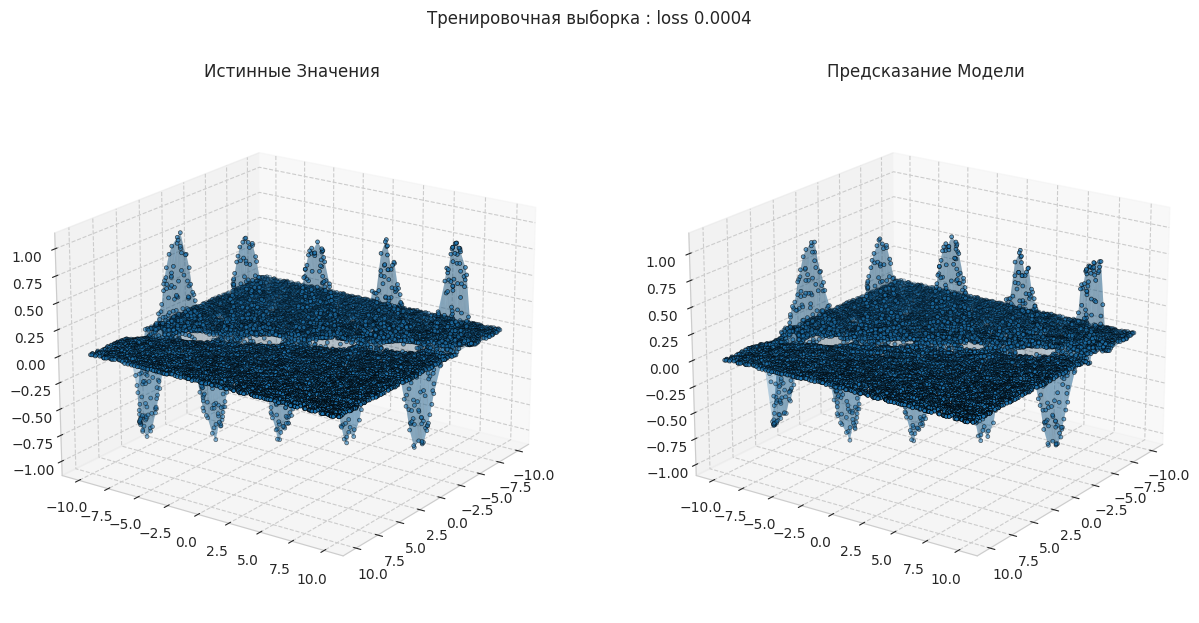

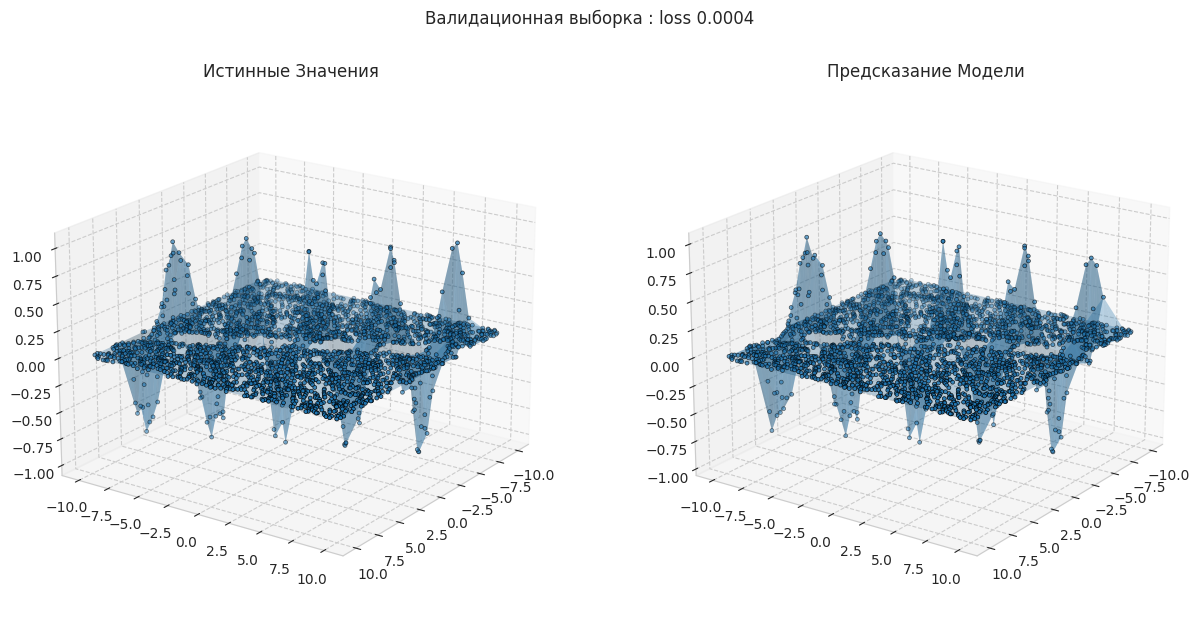

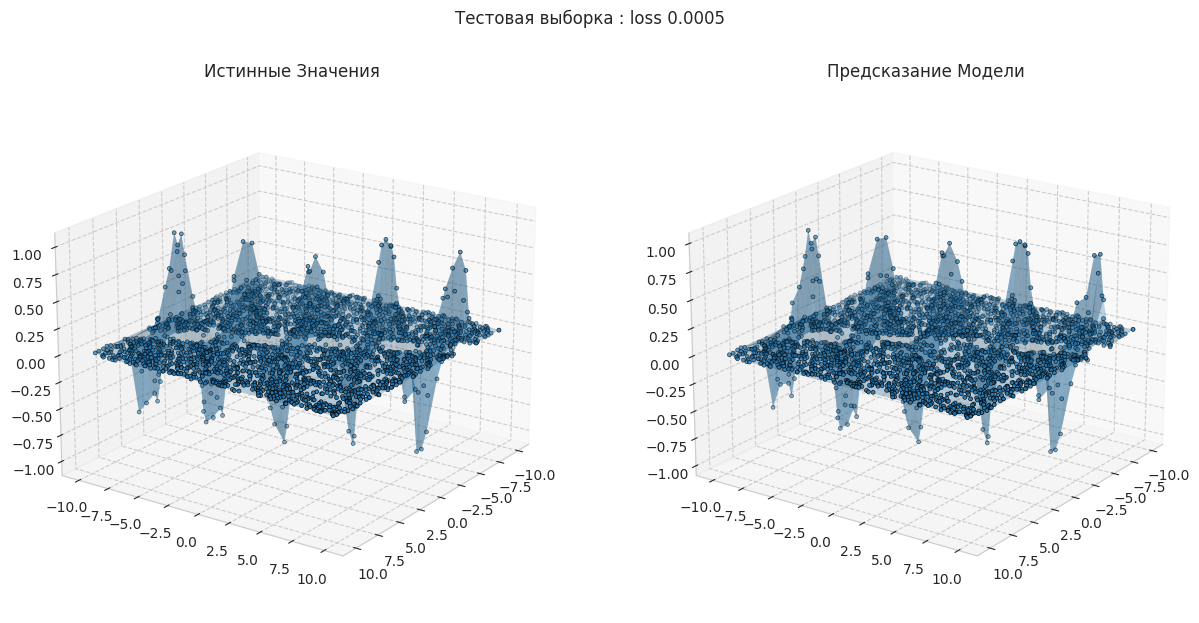

In [41]:
compare_pred(model,x_train,y_train,'Тренировочная выборка'); plt.show()
compare_pred(model,x_val,y_val,'Валидационная выборка'); plt.show()
compare_pred(model,x_test,y_test,'Тестовая выборка'); plt.show()